In [30]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as plt
from PIL import Image
sys.path.append('../src')
from utils import *
import seaborn as sns
from matplotlib.lines import Line2D
import cv2
import matplotlib as mpl

In [47]:
folder   = "SCS VD PCA LR 10:250:5 0.6 Exp3 AE"
log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

# folder   = "SCS VD PCA LR 10:250:5 0.3 Exp2 AE"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

# folder   = "SCS VD PCA LR 10:250:5 0.4 Exp AE"
# # log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_50.csv"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

df = pd.read_csv(log_path)
df.head(60)

# Sample Indicator: 
#   0 --> Ground Truth
#   1 --> Ground Truth CLIP
#   2 --> Decoded CLIP Only
#   3 --> Search Reconstruction

,Unnamed: 0,ID,Iter,Sample Indicator,Strength,Brain Correlation V1,Brain Correlation V2,Brain Correlation V3,Brain Correlation V4,Brain Correlation Early Visual,Brain Correlation Higher Visual,Brain Correlation Unmasked,SSIM,Pixel Correlation,CLIP Pearson,CLIP Two-way
0,0,0,0.0,NaN,1.0000,0.724189,0.702799,0.639894,0.688006,0.699857,0.731820,0.727151,0.547651,0.517761,0.596072,NaN
1,1,0,1.0,NaN,0.9994,0.759994,0.731020,0.710672,0.609233,0.725420,0.748923,0.751516,0.524471,0.663268,0.596072,NaN
2,2,0,2.0,NaN,0.9952,0.781661,0.783527,0.773241,0.806506,0.785336,0.870158,0.816462,0.539549,0.429006,0.596072,NaN
3,3,0,3.0,NaN,0.9838,0.754849,0.794979,0.846318,0.831575,0.800304,0.693563,0.790533,0.563425,0.528424,0.596072,NaN
4,4,0,4.0,NaN,0.9616,0.795123,0.739221,0.780071,0.886492,0.789601,0.769952,0.800710,0.576139,0.573588,0.596072,NaN
5,5,0,5.0,NaN,0.9250,0.712270,0.760980,0.720003,0.777944,0.743367,0.834039,0.772523,0.586425,0.237378,0.596072,NaN
6,6,0,6.0,NaN,0.8704,0.758844,0.739403,0.721822,0.751179,0.742533,0.827455,0.777702,0.557441,0.443157,0.596072,NaN
7,7,0,7.0,NaN,0.7942,0.802179,0.799652,0.821983,0.812022,0.808905,0.781592,0.817725,0.546008,0.373850,0.596072,NaN
8,8,0,8.0,3.0,0.6928,0.788685,0.781883,0.816324,0.842387,0.799007,0.862541,0.823129,0.519804,0.201213,0.596072,0.999999
9,9,0,9.0,NaN,0.5626,0.798486,0.778454,0.832485,0.898491,0.810809,0.794769,0.820187,0.503757,0.187680,0.596072,NaN


In [7]:
# Statistical Analysis

# ------------------------------------------ Quantitative Measures -----------------------------
#     Methods       |  PixCorr |  SSIM  |  CLIP |
#                   |          |        |       |          
#  Takagi et al.    |          |        | 77.0% |
#  Stable Diffusion |   .150   |  .325  |       |
#  Brain-Diffuser   |   .254   |  .356  | 91.5% |

# Final Sample Mean SSIM:  0.24619865488800002
# Final Sample Mean Pixel Correlation:  0.18779825951199997
# Final Sample Mean CLIP Pearson:  0.6848930502039999
# Final Sample Mean CLIP Two-way:  0.9188355520279999


df_final_samples = df.loc[(df['Sample Indicator'] == 3.0)]

print("Final Sample Mean SSIM: ", df_final_samples['SSIM'].mean())

print("Final Sample Mean Pixel Correlation: ", df_final_samples['Pixel Correlation'].mean())

print("Final Sample Mean CLIP Pearson: ", df_final_samples['CLIP Pearson'].mean())

print("Final Sample Mean CLIP Two-way: ", df_final_samples['CLIP Two-way'].mean())

Final Sample Mean SSIM:  0.270309630946
Final Sample Mean Pixel Correlation:  0.22553186589399998
Final Sample Mean CLIP Pearson:  0.646361334914
Final Sample Mean CLIP Two-way:  0.9124395386199999


     Unnamed: 0  ID  Iter  Sample Indicator  Strength  Brain Correlation V1  \
12           12   0   NaN               0.0    0.5626              0.908820   
25           25   1   NaN               0.0    0.5626              0.866193   
38           38   2   NaN               0.0    0.5626              0.936503   
51           51   3   NaN               0.0    0.5626              0.872334   
64           64   4   NaN               0.0    0.5626              0.887856   
77           77  25   NaN               0.0    0.5626              0.490988   
90           90  26   NaN               0.0    0.5626              0.804160   
103         103  27   NaN               0.0    0.5626              0.810127   
116         116  28   NaN               0.0    0.5626              0.739080   
129         129  29   NaN               0.0    0.5626              0.789306   

     Brain Correlation V2  Brain Correlation V3  Brain Correlation V4  \
12               0.874150              0.858289          

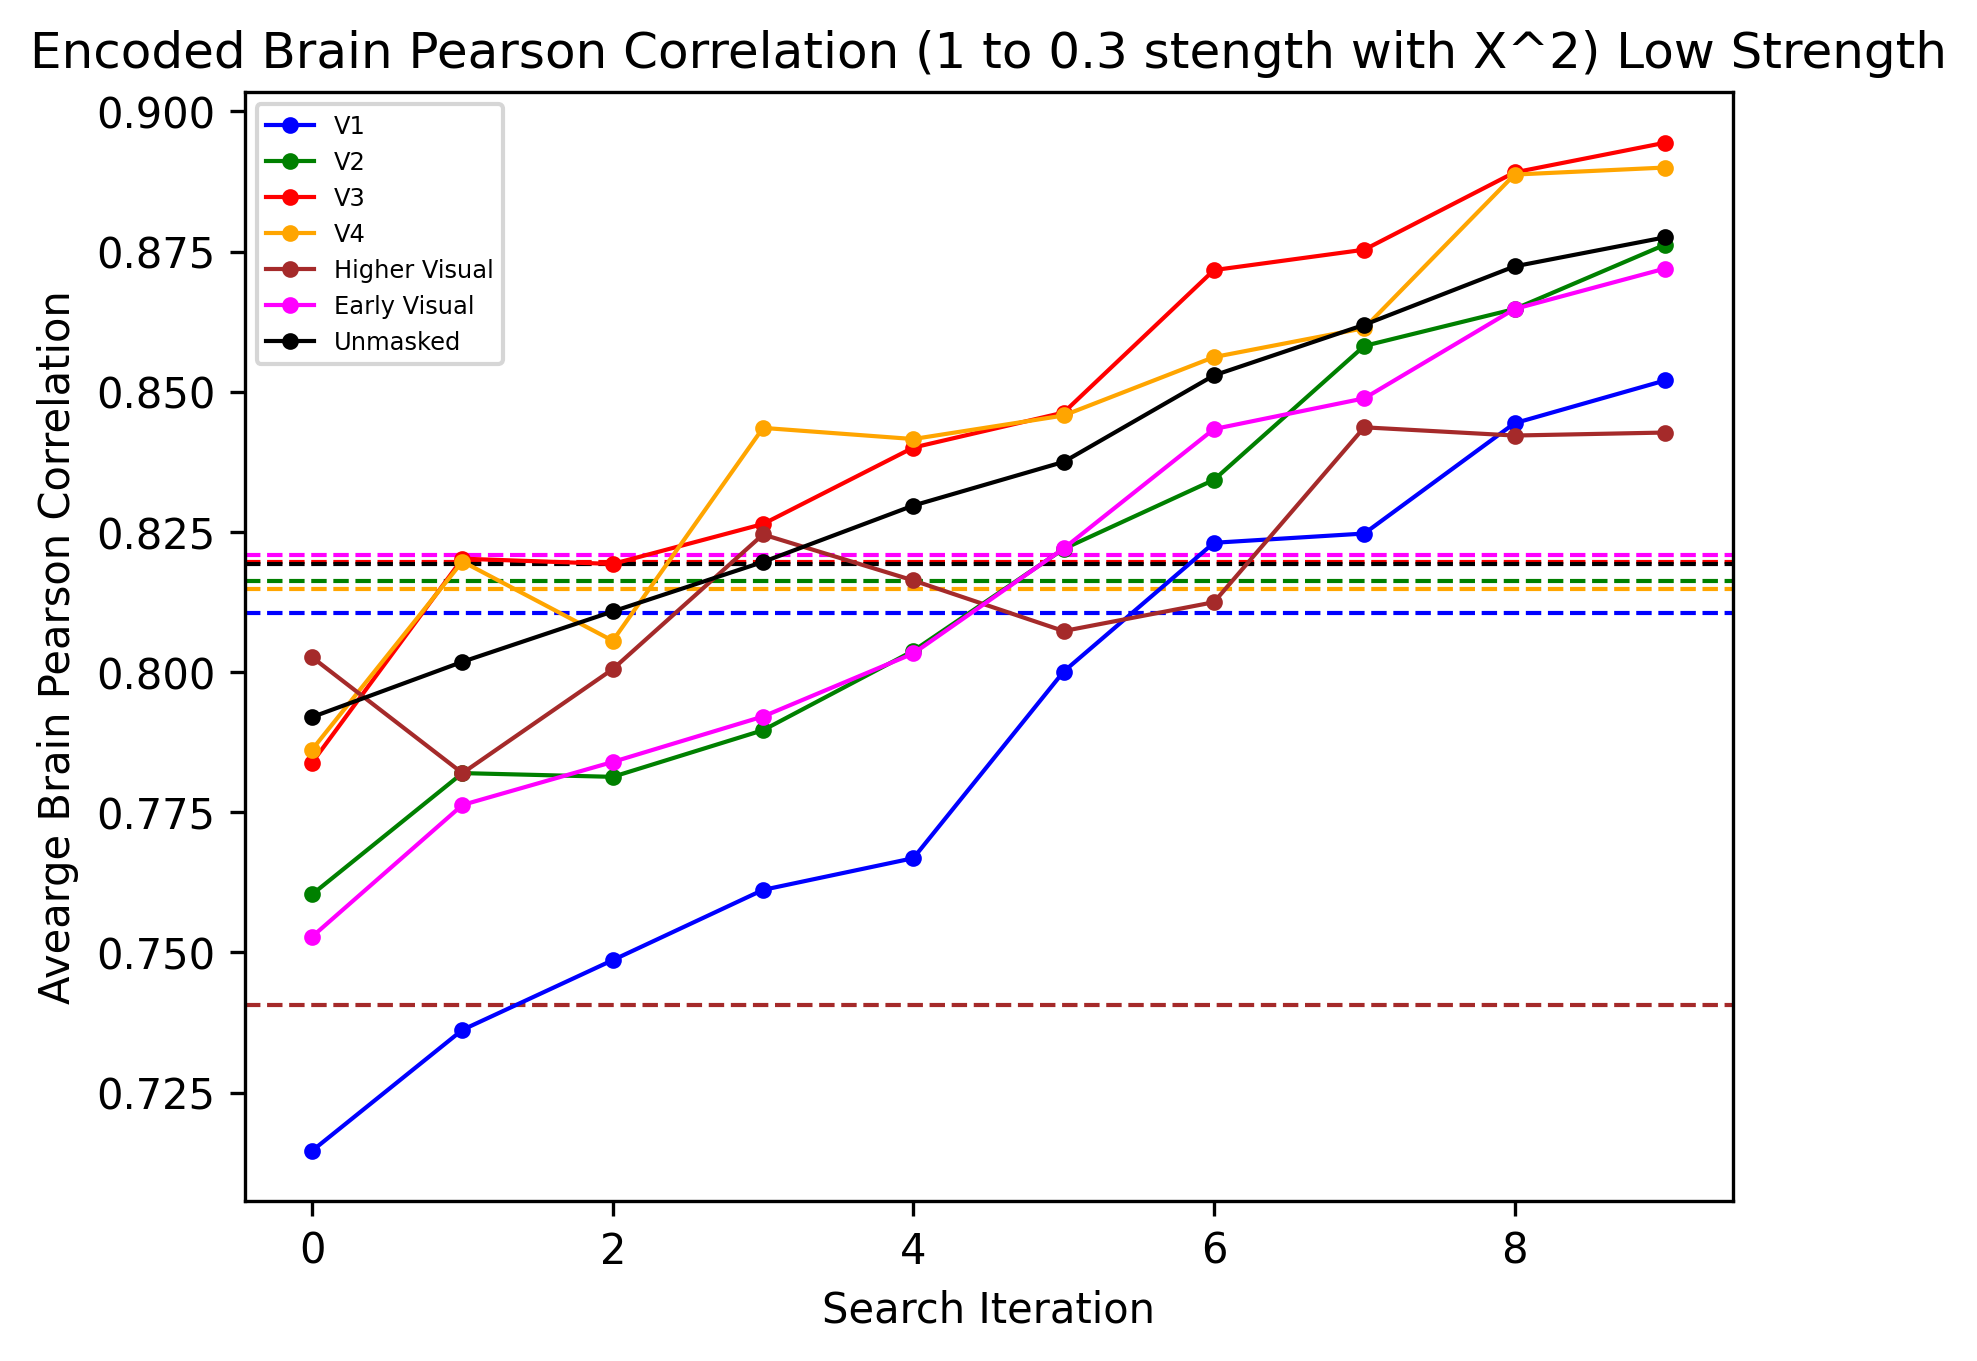

In [46]:
# Average Iteration Brain Region Plot
print(df.loc[(df['Sample Indicator'] == 0.0)])

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []
brain_correlation_ground_truth = []

for iteration in range(10):
    
    iteration_val_v1 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V1'].mean()
    iteration_val_v2 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V2'].mean()
    iteration_val_v3 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V3'].mean()
    iteration_val_v4 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V4'].mean()
    iteration_val_ev = df.loc[(df['Iter'] == iteration)]['Brain Correlation Early Visual'].mean()
    iteration_val_hv = df.loc[(df['Iter'] == iteration)]['Brain Correlation Higher Visual'].mean()
    iteration_val_unmasked = df.loc[(df['Iter'] == iteration)]['Brain Correlation Unmasked'].mean()
    
    brain_correlation_V1.append(iteration_val_v1)
    brain_correlation_V2.append(iteration_val_v2)
    brain_correlation_V3.append(iteration_val_v3)
    brain_correlation_V4.append(iteration_val_v4)
    brain_correlation_early_visual.append(iteration_val_ev)
    brain_correlation_higher_visual.append(iteration_val_hv)
    brain_correlation_unmasked.append(iteration_val_unmasked)
    

plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), color = 'blue', linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), color = 'green', linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), color = 'red',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), color = 'orange',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), color = 'brown', linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(),  color = 'magenta',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), color = 'black', linestyle = 'dashed', linewidth=1)

plt.plot(brain_correlation_V1, marker='.', color = 'blue', label = 'V1', linewidth=1)
plt.plot(brain_correlation_V2, marker='.', color = 'green',label = 'V2', linewidth=1)
plt.plot(brain_correlation_V3, marker='.', color = 'red',  label = 'V3', linewidth=1)
plt.plot(brain_correlation_V4, marker='.', color = 'orange', label = 'V4', linewidth=1)
plt.plot(brain_correlation_higher_visual, marker='.', color = 'brown', label = 'Higher Visual', linewidth=1)
plt.plot(brain_correlation_early_visual, marker='.',  color = 'magenta', label = 'Early Visual', linewidth=1)
plt.plot(brain_correlation_unmasked, marker='.',  color = 'black', label = 'Unmasked', linewidth=1)

plt.legend(fontsize = "xx-small")
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation (1 to 0.6 stength with X^3) High Strength")
mpl.rcParams['figure.dpi'] = 300

False
False
False
False
False
False
False
here
True
here
True
here
True
here


Text(0.5, 1.0, 'Encoded Brain Pearson Correlation')

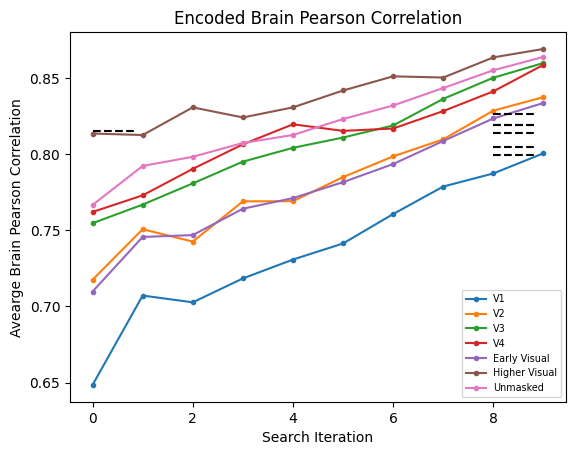

In [11]:
# Average Iteration Brain Region Plot

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []
brain_correlation_ground_truth = []

y_v1 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean()
y_v2 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean()
y_v3 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean()
y_v4 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean()
y_ev = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean()
y_hv = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean()
y_unmasked = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean()

v1_set = True
v2_set = True
v3_set = True
v4_set = True
ev_set = True
hv_set = True
unmasked_set = True

x_v1 = 0 
x_v2 = 0 
x_v3 = 0 
x_v4 = 0 
x_ev = 0 
x_hv = 0 
x_umasked = 0 

for iteration in range(10):
    
    iteration_val_v1 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V1'].mean()
    iteration_val_v2 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V2'].mean()
    iteration_val_v3 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V3'].mean()
    iteration_val_v4 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V4'].mean()
    iteration_val_ev = df.loc[(df['Iter'] == iteration)]['Brain Correlation Early Visual'].mean()
    iteration_val_hv = df.loc[(df['Iter'] == iteration)]['Brain Correlation Higher Visual'].mean()
    iteration_val_unmasked = df.loc[(df['Iter'] == iteration)]['Brain Correlation Unmasked'].mean()
    
    brain_correlation_V1.append(iteration_val_v1)
    brain_correlation_V2.append(iteration_val_v2)
    brain_correlation_V3.append(iteration_val_v3)
    brain_correlation_V4.append(iteration_val_v4)
    brain_correlation_early_visual.append(iteration_val_ev)
    brain_correlation_higher_visual.append(iteration_val_hv)
    brain_correlation_unmasked.append(iteration_val_unmasked)
    
    print(v3_set)
    if(iteration_val_v1 > y_v1 and v1_set):
        x_v1 = iteration - 1
        v1_set = False
        
    if(iteration_val_v2 > y_v2 and v2_set):
        x_v2 = iteration - 1
        v2_set = False
        
    if(iteration_val_v3 > y_v3 and v3_set):
        x_v3 = iteration - 1
        v3_set = False
        
    if(iteration_val_v4 > y_v4 and v4_set):
        x_v4 = iteration - 1
        v4_set = False
        
    if(iteration_val_ev > y_ev and ev_set):
        x_ev = iteration - 1
        ev_set = False
        
    if(iteration_val_hv > y_hv and hv_set):
        x_hv = iteration - 1
        hv_set = False
        
    if(iteration_val_unmasked > y_unmasked and unmasked_set):
        print("here")
        x_unmasked = iteration - 1
        unmasked_set = False
    
# print(df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean())
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), linestyle = 'dashed', label = 'Brain Correlation Unmasked')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), linestyle = '-', label = 'Brain Correlation V1')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), linestyle = '-', label = 'Brain Correlation V2')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), linestyle = '-', label = 'Brain Correlation V3')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), linestyle = '-', label = 'Brain Correlation V4')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')

# ci = 1.96 * np.std(y)/np.sqrt(len(x))


plt.plot(brain_correlation_V1, marker='.', label = 'V1')
plt.plot(brain_correlation_V2, marker='.', label = 'V2')
plt.plot(brain_correlation_V3, marker='.', label = 'V3')
plt.plot(brain_correlation_V4, marker='.', label = 'V4')
plt.plot(brain_correlation_early_visual, marker='.', label = 'Early Visual')
plt.plot(brain_correlation_higher_visual, marker='.', label = 'Higher Visual')
plt.plot(brain_correlation_unmasked, marker='.', label = 'Unmasked')

plt.plot([x_v1, x_v1 + 0.85], [y_v1, y_v1] , color = 'black', linestyle="dashed")
plt.plot([x_v2, x_v2 + 0.85], [y_v2, y_v2] , color = 'black', linestyle="dashed")
plt.plot([x_v3, x_v3 + 0.85], [y_v3, y_v3] , color = 'black', linestyle="dashed")
plt.plot([x_v4, x_v4 + 0.85], [y_v4, y_v4] , color = 'black', linestyle="dashed")
plt.plot([x_ev, x_ev + 0.85], [y_ev, y_ev] , color = 'black', linestyle="dashed")
plt.plot([x_hv, x_hv + 0.85], [y_hv, y_hv] , color = 'black', linestyle="dashed")
plt.plot([x_unmasked, x_unmasked + 0.85], [y_unmasked, y_unmasked] , color = 'black', linestyle="dashed")
#plt.axhline(x = [1,3], y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), linestyle = 'dashed', label = 'Brain Correlation Unmasked')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), linestyle = '-', label = 'Brain Correlation V1')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), linestyle = '-', label = 'Brain Correlation V2')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), linestyle = '-', label = 'Brain Correlation V3')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), linestyle = '-', label = 'Brain Correlation V4')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
plt.legend(fontsize = "x-small")
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation")


Text(0.5, 1.0, 'Encoded Brain Pearson Correlation Unmasked')

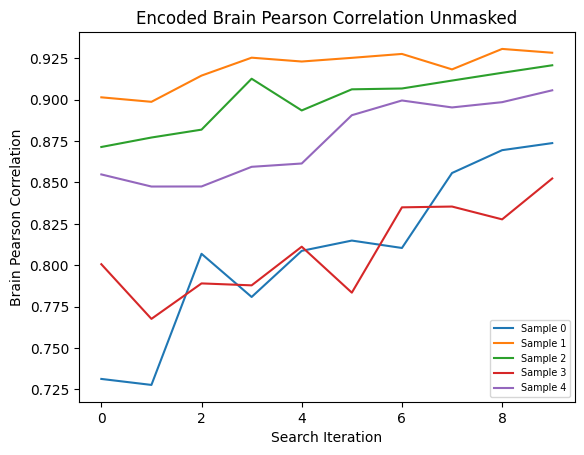

In [14]:
# Single Iteration Brain Region Plot

sample_0 = []
sample_1 = []
sample_2 = []
sample_3 = []
sample_4 = []
sample_5 = []
sample_6 = []
sample_7 = []
sample_8 = []
sample_9 = []

for iteration in range(10):
    sample_0.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 0)]['Brain Correlation Unmasked'])
    sample_1.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 1)]['Brain Correlation Unmasked'])
    sample_2.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 2)]['Brain Correlation Unmasked'])
    sample_3.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 3)]['Brain Correlation Unmasked'])
    sample_4.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 4)]['Brain Correlation Unmasked'])
    sample_5.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 5)]['Brain Correlation Unmasked'])
    sample_6.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 6)]['Brain Correlation Unmasked'])
    sample_7.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 7)]['Brain Correlation Unmasked'])
    sample_8.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 8)]['Brain Correlation Unmasked'])
    sample_9.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 9)]['Brain Correlation Unmasked'])


plt.plot(sample_0, label = 'Sample 0')
plt.plot(sample_1, label = 'Sample 1')
plt.plot(sample_2, label = 'Sample 2')
plt.plot(sample_3, label = 'Sample 3')
plt.plot(sample_4, label = 'Sample 4')
plt.plot(sample_5, label = 'Sample 5')
plt.plot(sample_6, label = 'Sample 6')
plt.plot(sample_7, label = 'Sample 7')
plt.plot(sample_8, label = 'Sample 8')
plt.plot(sample_9, label = 'Sample 9')
plt.legend(fontsize = "x-small")
plt.xlabel("Search Iteration")
plt.ylabel("Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation Unmasked")